<a href="https://colab.research.google.com/github/dinhngoc267/exploratory_data_analysis/blob/main/Customer_Behaviour_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dữ liệu:**

> Tập dữ liệu bao gồm các logs hoạt động của người dùng đối với các dịch vụ TV

– MAC: userID

– SessionMainMenu: thời điểm user bắt đầu sử dụng dịch vụ

– AppName: loại app user sử dụng

– LogID: mã log

– Event: thao tác user

– ItemID: ID chương trình user xem

– RealTimePlaying: thời lượng xem của user

> Và tập dữ liệu số ngày sử dụng dịch vụ của các user

### Import Lib

In [1]:
#@title
pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 5.3 MB/s eta 0:00:00


In [3]:
#@title
import patoolib
import numpy as np
import pandas as pd
import glob
import re
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


os.makedirs("/content/logs")
patoolib.extract_archive("/content/drive/MyDrive/DataSampleTest.rar", outdir="/content/logs")

patool: Extracting /content/drive/MyDrive/DataSampleTest.rar ...
patool: running /usr/bin/unrar x -- /content/drive/MyDrive/DataSampleTest.rar
patool:     with cwd='/content/logs'
patool: ... /content/drive/MyDrive/DataSampleTest.rar extracted to `/content/logs'.


'/content/logs'

### Process Data

In [14]:
#@title
class LogParser():
  def __init__(self, pattern = r'''u'(.*?)'|(\d+)|u"(.*?)"'''):
    self.pattern = pattern

  def text_to_list_json(self, data_dir):
    """
    data_dir: directory of log files
    """

    data = []
    files = glob.glob(os.path.join(data_dir, "*.txt"))

    for file_name in tqdm(files):
      with open(file_name) as f:
        
        lines = f.read().split('\n')

        for line in lines:
          row = {}
          matches = re.findall(self.pattern, line)
          items = []

          for item in matches:
            flag = False
            for group in item:
              if group != "":
                flag = True
                items.append(group)
                break
            if flag == False:
              items.append("")
          try:
            for i in range(0,len(items),2):
              row[items[i]] = items[i+1]
          except:
            print('Error in {} file. Found {} group match'.format(file_name, len(matches)))
          
          data.append(row)

    return data

  def export_log(self, list_json, extracted_fields, output_file):
    """

    """

    with open(output_file, "w") as f:
      strings = []
      f.write('\t'.join(extracted_fields) + '\n')

      for row in list_json:
        tmp = []

        for field in extracted_fields:
          if field in row:
            tmp.append(row[field])
          else:
            tmp.append("")

        strings.append('\t'.join(tmp))
        
      f.write('\n'.join(strings))

In [469]:
data_dir = "/content/logs"
files = glob.glob(os.path.join(data_dir, "*.txt"))
count = 0
for file_name in tqdm(files):
  with open(file_name) as f:
    
    data = f.read()
    
    count += data.count("")

100%|██████████| 7/7 [00:03<00:00,  1.86it/s]


In [15]:
#@title
logParser = LogParser()
extracted_fields = ['Mac', 'SessionMainMenu', 'AppName', 'LogId', 'Event', 'ItemId', 'RealTimePlaying']
data = logParser.text_to_list_json("/content/logs")

100%|██████████| 7/7 [00:54<00:00,  7.73s/it]


In [17]:
#@title
logParser.export_log(data, extracted_fields, "/content/new_log.txt")

## EDA

#### Load Data

In [562]:
#@title
with open("/content/new_log.txt") as f:
  lines = f.read().split('\n')

  fields = lines[0].split('\t')
  lines = lines[1:]

  data = []
  for line in lines:
    line = line.split('\t')

    row = {}
    for i in range(len(line)):
      row[fields[i]] = line[i]

    data.append(row)
df = pd.DataFrame(data)

#@title
with open("user_info.txt") as f:
  lines = f.read().split('\n')
  lines = lines[1:]

  data = []
  
  for line in lines:
    row = {}
    line = line.split('\t')
    row['Mac'] = line[0]
    row['n_days_use'] = line[1] 
    data.append(row)

n_days_use_df =  pd.DataFrame(data)

def normalizeID(x):
  return x.replace("FBOX", "")

n_days_use_df['Mac'] = n_days_use_df['Mac'].apply(lambda x: normalizeID(x))

### Process Data

#### Merge dữ liệu và xóa trùng lặp

In [563]:
df = df.merge(n_days_use_df, how = 'inner')
df.drop_duplicates(inplace=True)
df.shape

(788101, 8)

#### Chuyển đổi kiểu dữ liệu cho các cột

##### DateTime cho cột `SessionMainMenu`

In [564]:
#@title
def extract_datetime(string):
  return ':'.join(string.split(':')[1:-1])

df['SessionMainMenu'] = df['SessionMainMenu'].apply(lambda x: extract_datetime(x))

df[df['SessionMainMenu'] == ""] = None
df['SessionMainMenu'] = pd.to_datetime(df['SessionMainMenu'], format='%Y:%m:%d:%H:%M:%S')

df.head()

,Mac,SessionMainMenu,AppName,LogId,Event,ItemId,RealTimePlaying,n_days_use
0,B046FCAC0DC1,2016-02-12 12:35:13,VOD,52,StopVOD,100052388,570.3,375
1,B046FCAC0DC1,2016-02-11 01:01:56,IPTV,40,EnterIPTV,,,375
2,B046FCAC0DC1,2016-02-11 01:02:29,VOD,55,NextVOD,100052388,,375
3,B046FCAC0DC1,2016-02-12 04:44:59,IPTV,18,ChangeModule,,,375
4,B046FCAC0DC1,2016-02-12 12:35:13,VOD,54,PlayVOD,100052388,,375


##### Số thực cho cột `RealTimePlaying`

In [565]:
#@title
def to_float(x):
  try:
    return float(x)
  except:
    return None
df['RealTimePlaying'] = df['RealTimePlaying'].apply(lambda x: to_float(x))

##### Số nguyên cho cột `n_days_use`

In [566]:
#@title
def to_int(x):
  try:
    return int(x)
  except:
    return None
df['n_days_use'] = df['n_days_use'].apply(lambda x: to_int(x))

In [567]:
#@title
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 788101 entries, 0 to 1028790
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Mac              788079 non-null  object        
 1   SessionMainMenu  788079 non-null  datetime64[ns]
 2   AppName          788079 non-null  object        
 3   LogId            788079 non-null  object        
 4   Event            788079 non-null  object        
 5   ItemId           788079 non-null  object        
 6   RealTimePlaying  293035 non-null  float64       
 7   n_days_use       788079 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 54.1+ MB


### Tổng quan

#### **1. Số ngày sử dụng trước khi hủy dịch vụ của khách hàng**

In [572]:
#@title
df['n_days_use'].describe()

count    788079.000000
mean        237.260048
std         169.969920
min           0.000000
25%          68.000000
50%         236.000000
75%         390.000000
max         976.000000
Name: n_days_use, dtype: float64

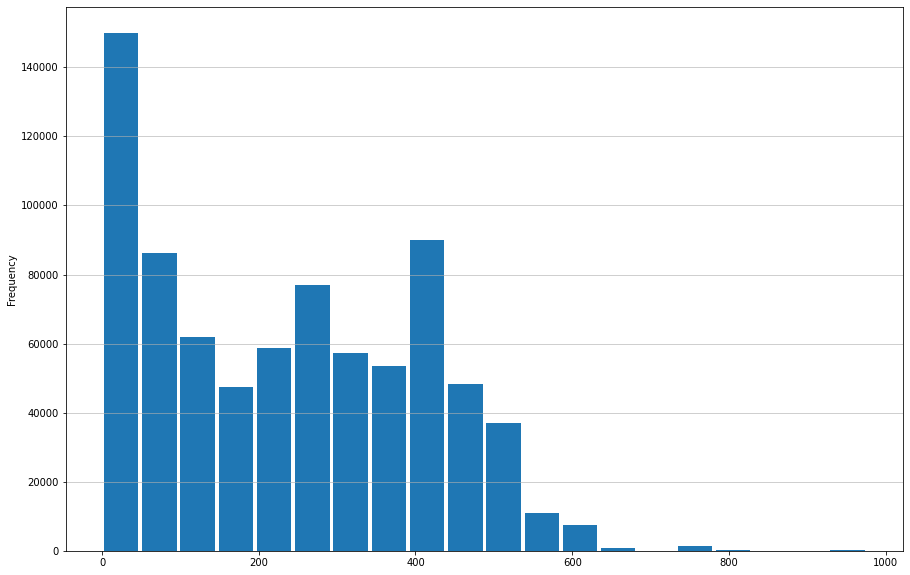

In [573]:
#@title 
plt.figure(figsize=(15,10))

df['n_days_use'].plot.hist(bins = 20, rwidth=0.9,)
plt.grid(axis='y', alpha=0.75)
plt.show()

In [582]:
#@title
n_days_use_df['n_days_use'] = n_days_use_df['n_days_use'].astype(int)
def classify(x):
  if x < 30:
    return "Duoi 1 thang"
  elif x < 180:
    return "Tu 1 den 6 thang"
  elif x < 356:
    return "Tu 6 thang den 1 nam"
  elif x < 534:
    return "Tu 1 den 1.5 nam"
  elif x < 712:
    return "Tu 1.5 den 2 nam"
  else:
    return "Tren 2 nam"

n_days_use_df['Category'] = n_days_use_df['n_days_use'].apply(lambda x: classify(x))
n_days_use_df['Category'].value_counts()

Tu 6 thang den 1 nam    792
Tu 1 den 1.5 nam        746
Tu 1 den 6 thang        713
Duoi 1 thang            228
Tu 1.5 den 2 nam        118
Tren 2 nam               95
Name: Category, dtype: int64

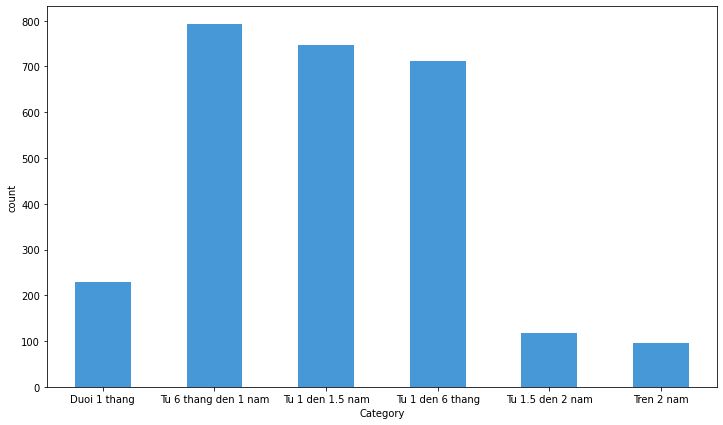

In [583]:
#@title
plt.figure(figsize=(12,7))
sns.countplot(x = 'Category', data = n_days_use_df, color=(39/255, 156/255, 245/255, 0.9), width=0.5, saturation=0.7)
plt.show()

> **Kết luận:**

>> **50% khách hàng hủy dịch vụ chỉ sử dụng trong khoảng 9 tháng và 25% số khách hàng hủy dịch vụ chỉ sử dụng trong 6 tháng**


#### **2. Hành vi sử dụng của các khách hàng hủy dịch vụ**

##### **2.1 Khách hàng thường xem gì?**

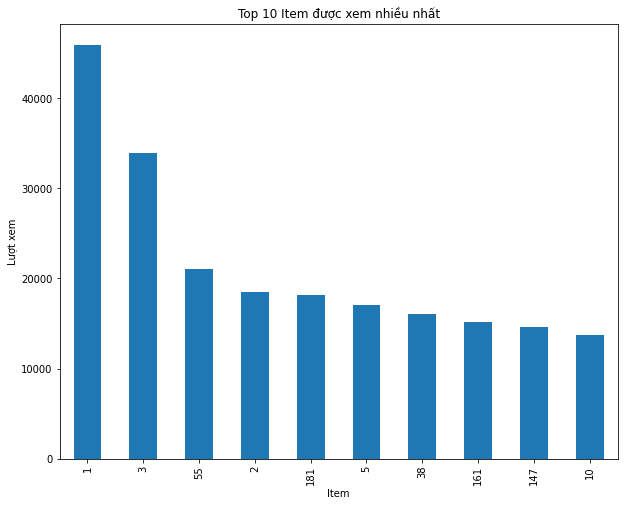

In [584]:
#@title
plt.figure(figsize=(10,8))
most_view_item = df['ItemId'].value_counts()[1:11]
most_view_item.plot.bar()
plt.ylabel('Lượt xem')
plt.xlabel('Item')
plt.title('Top 10 Item được xem nhiều nhất')
plt.show()

##### **2.2 Số lượt tương tác với dịch vụ của khách hàng giữa các tháng trong năm**

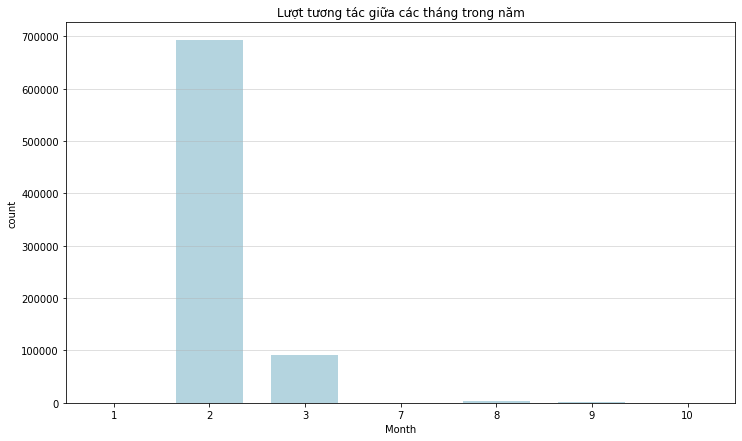

In [635]:
df['Month'] = df['SessionMainMenu'].dt.month
df['Month'].value_counts()

#@title
plt.figure(figsize=(12,7))
#df['Month'].plot.bar()
sns.countplot(df, x= 'Month', color = 'lightblue', width=0.7)
plt.title('Lượt tương tác giữa các tháng trong năm')
plt.grid(axis='y', alpha=0.5)
plt.show()

> **Nhận xét**:

>> **Trong tập logs chỉ chưa thông tin của tháng 1, 2, 3, 8, 9, 10**

>> **Khách hàng tương tác nhiều nhất với dịch vụ chủ yếu vào tháng 2 có thể rơi vào dịp lễ Tết** 

#### **2.2 Thời gian trung bình xem TV mỗi ngày của khách hàng qua thời gian**

In [590]:
#@title
def get_date(x):
  try:
    return x.date()
  except:
    return None

df['Date'] = df['SessionMainMenu'].apply(lambda x: get_date(x))

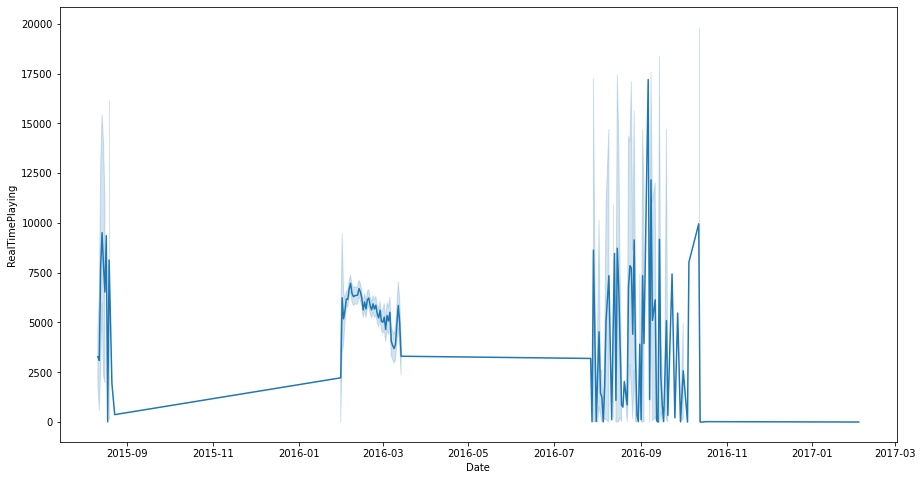

In [592]:
group = df.groupby(by=['Mac', 'Date']).agg({'RealTimePlaying':'sum'}).reset_index()
group = group[group['RealTimePlaying'] < 2e+04]
plt.figure(figsize=(15,8))
sns.lineplot(data= group, x='Date', y = 'RealTimePlaying')
plt.show()

> **Nhận xét:**

>> **Mặc dù tháng 2 là tháng có nhiều lượt tương tác nhất trong năm. Nhưng giai đoạn tháng 8 và 9 mới là giai đoạn có thời gian khách hàng xem TV nhiều nhất.**

##### **2.2 Khách hàng thường xem vào thời điểm nào trong tuần?**

In [593]:
#@title
def get_weekday_name(x):
  try:
    return x.strftime('%A')
  except:
    return None

df['WeekdayName'] = df['SessionMainMenu'].apply(lambda x: get_weekday_name(x))

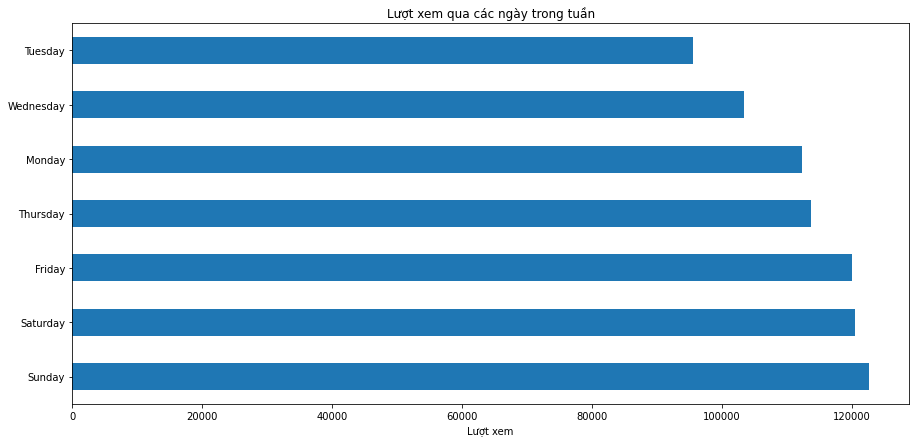

In [594]:
#@title
plt.figure(figsize=(15,7))
freq = df['WeekdayName'].value_counts()
freq.plot.barh()
plt.xlabel('Lượt xem')
plt.title('Lượt xem qua các ngày trong tuần')
plt.show()

> **Nhận xét:**

>> **Khách hàng chủ yếu xem vào các ngày cuối tuần.**


>> **Lượt xem thấp nhất là vào giữa tuần**

##### **2.3 Khách hàng thường xem vào thời điểm nào trong ngày?**

In [595]:
#@title
def extract_hour(x):
  try:
    return x.hour
  except:
    return None

df['Hour'] = df['SessionMainMenu'].apply(lambda x: extract_hour(x))

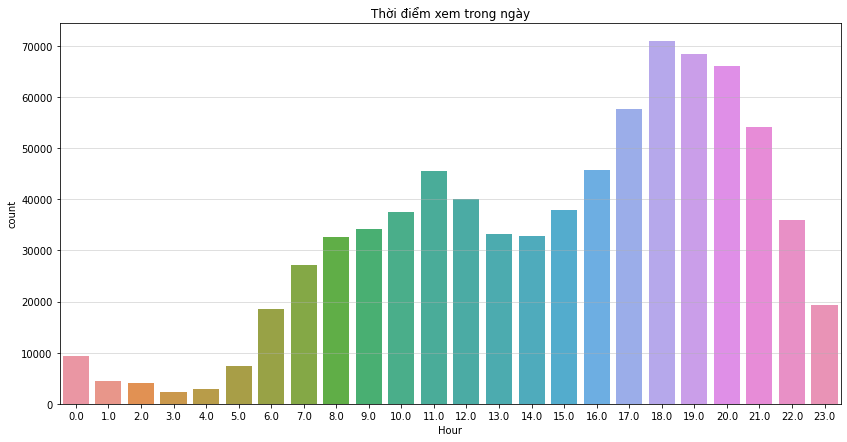

In [596]:
#@title
plt.figure(figsize=(14,7))
sns.countplot(df, x= 'Hour')
plt.title('Thời điểm xem trong ngày')
plt.grid(axis='y', alpha=0.5)
plt.show()

> **Nhận xét:**

>> **Ta thấy rằng biểu đồ có 2 đỉnh. Đỉnh thứ nhất rơi vào khung giờ trưa từ 11 - 12 giờ. Đỉnh thứ 2 rơi vào khung giờ tối từ 18 - 20 giờ.**

>> **Ta cũng thấy rằng đỉnh thứ 2 cao hơn đỉnh 1 khoảng 1.5 lần. Cho thấy tập quán xem tivi vào buổi tối của các gia đình**

##### **2.4 Khách hàng thường xem bao lâu mỗi ngày?** 

In [598]:
#@title
watching_time = df[(np.isnan(df['RealTimePlaying']) == False)]
watching_time = watching_time.groupby(by = ['Mac', 'Date']).agg({'RealTimePlaying':'sum'}).reset_index().rename(columns={'RealTimePlaying':'Duration'})
watching_time =  watching_time['Duration']                                                       
watching_time.describe()

count    2.254900e+04
mean     1.616739e+04
std      2.656339e+05
min      3.920000e-01
25%      1.774055e+03
50%      6.337615e+03
75%      1.469622e+04
max      3.121355e+07
Name: Duration, dtype: float64

> **Có một vài giá trị ngoại lai. Để thấy rõ phân bố thời gian xem trên biểu đồ ta sẽ loại bỏ các giá trị ngoại lai này**

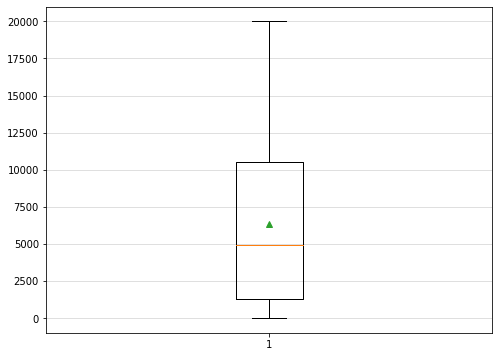

In [599]:
#@title
watching_time = watching_time[watching_time < 2e+04]
plt.figure(figsize=(8,6))
plt.boxplot(watching_time, showmeans=True, showcaps=True)
plt.grid(axis='y', alpha=0.5)
plt.show()

> **Nhận xét:**

>> **Có sự chênh lệch lớn về thời gian xem chương trình giữa các người dùng**

>> **Thời gian xem trung bình 1 ngày là 6300 đơn vị thời gian**

##### **2.5 Tần suất tương tác với dịch vụ của khách hàng mỗi ngày**

In [600]:
#@title
interact_freq = df.groupby(by = ['Mac', 'Date']).agg({'Event':'count'}).reset_index()
interact_freq.describe()

,Event
count,24077.000000
mean,32.731611
std,42.973854
min,1.000000
25%,9.000000
50%,22.000000
75%,42.000000
max,2356.000000


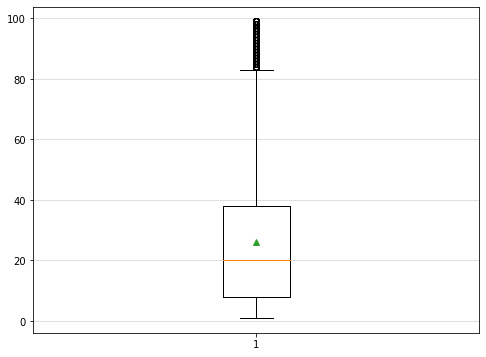

In [601]:
#@title
# Loai bo outlier:

interact_freq = interact_freq[interact_freq['Event'] < 100]['Event']
plt.figure(figsize=(8,6))
plt.boxplot(interact_freq, showmeans=True, showcaps=True)
plt.grid(axis='y', alpha=0.5)
plt.show()

> **Trung bình một ngày một khách hàng sẽ có 23 tương tác**

#### **3. Hành vi của khách hàng trước khi hủy dịch vụ**

> **Để nhìn được những điểm khác biệt về hành vi giữa 2 thời điểm:**

>> Thời điểm ngay trước lúc khách hàng hủy dịch vụ

>> Thời điểm khách hàng xem dịch vụ ổn định (tạm gọi là hài lòng)

> **Ta cắt dữ liệu ở 2 mốc đối với những khách hàng đăng kí lâu dài:**

>> 1 tháng trước khi khách hàng hủy dịch vụ

>> Các tháng trước mốc 1 tháng khách hàng hủy dịch vụ

> **Ta cũng phân tích hành vi những đối tượng đăng kí dưới 1 tháng**

> **Tuy nhiên dữ liệu log không đầy đủ từ thời điểm bắt đầu và kết thúc hợp đồng của các khách hàng gây khó khăn cho việc phân tích sự khác biệt**

> **Giả sử thời điểm log cuối cùng là thời điểm kết thúc hợp đồng**

In [602]:
#@title
log_first_last_date_use = df.groupby(by = ['Mac']).agg({'Date':['min', 'max']}).reset_index()#.rename(columns={'RealTimePlaying':'Duration'})
log_first_last_date_use['Diff'] = ((log_first_last_date_use[('Date', 'max')] - log_first_last_date_use[('Date', 'min')]))/ np.timedelta64(1, 'D')
log_first_last_date_use['FirstDate'] = log_first_last_date_use[('Date', 'min')]
log_first_last_date_use['LastDate'] = log_first_last_date_use[('Date', 'max')]
log_first_last_date_use.drop(columns='Date', inplace=True)
log_first_last_date_use.columns = [''.join(x) for x in log_first_last_date_use.columns]

<ipython-input-602-62e42ae10226>:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  log_first_last_date_use.drop(columns='Date', inplace=True)


In [603]:
#@title
log_first_last_date_use['Diff'].describe()

count    1693.000000
mean       35.906084
std        59.424864
min         0.000000
25%         9.000000
50%        21.000000
75%        29.000000
max       417.000000
Name: Diff, dtype: float64

> **Trong dữ liệu logs: Trung bình một người sử dụng dịch vụ 36 ngày.**

In [604]:
#@title
df = df.merge(log_first_last_date_use, how = 'inner',right_on = 'Mac',left_on = 'Mac')
def classify(row):
    if row['Diff'] <= 30:
      return 0
    elif row['Diff'] >= 60:
      if (row['LastDate'] - row['Date']).days > 30:
        return 1
      else:
        return 2
    else:
      return None

df['Category'] = df.apply(lambda row: classify(row), axis=1)

In [607]:
#@title
def classify(row):
    if row['n_days_use'] <= 30:
      return 0
    elif row['n_days_use'] >= 60:
      if (row['LastDate'] - row['Date']).days > 30:
        return 1
      else:
        return 2
    else:
      return None

df['Category'] = df.apply(lambda row: classify(row), axis=1)

##### **3.1 Khác biệt về thời gian xem mỗi ngày**

In [612]:
#@title
tmp = df[(np.isnan(df['RealTimePlaying']) == False)]
tmp = tmp.groupby(by = ['Mac', 'Date', 'Category']).agg({'RealTimePlaying':'sum'}).reset_index().rename(columns={'RealTimePlaying':'Duration'})


count    2.043300e+04
mean     1.639958e+04
std      2.784929e+05
min      3.920000e-01
25%      1.792334e+03
50%      6.336253e+03
75%      1.469533e+04
max      3.121355e+07
Name: Duration, dtype: float64

<ipython-input-616-b160e9a73661>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tmp = tmp[watching_time < 20e+03]


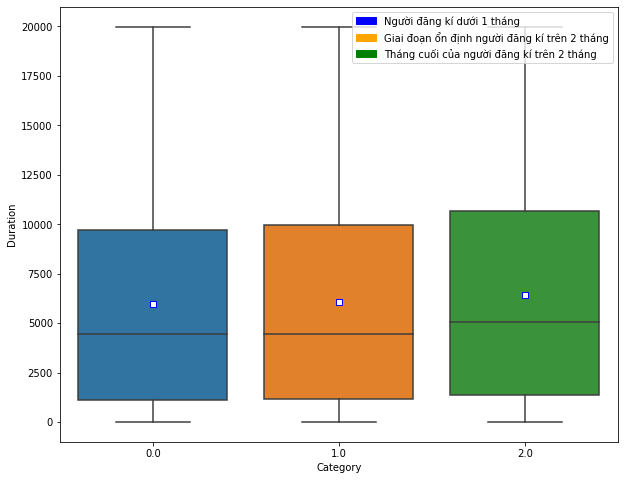

In [616]:
#@title
tmp = tmp[watching_time < 20e+03]
plt.figure(figsize=(10,8))
sns.boxplot(data=tmp, x='Category', y='Duration',showmeans=True, showcaps=True, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})
red_patch = mpatches.Patch(color='blue', label='Người đăng kí dưới 1 tháng')
a = mpatches.Patch(color='orange', label='Giai đoạn ổn định người đăng kí trên 2 tháng')
b = mpatches.Patch(color='green', label='Tháng cuối của người đăng kí trên 2 tháng')
plt.legend(handles=[red_patch, a, b], loc='upper right', fontsize=10)
plt.show()

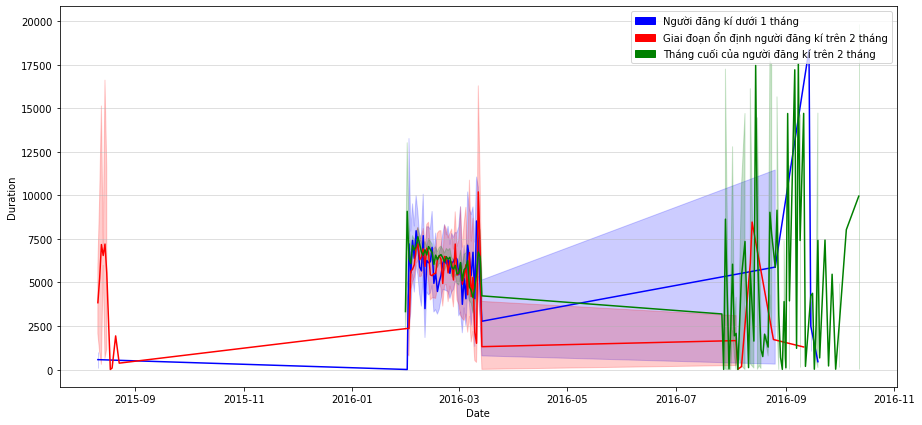

In [624]:
plt.figure(figsize=(15,7))
sns.lineplot(x='Date', 
             y='Duration',
             hue='Category', 
             palette=['b','r','g'],
             data=tmp)
plt.grid(axis='y', alpha=0.5)
red_patch = mpatches.Patch(color='blue', label='Người đăng kí dưới 1 tháng')
a = mpatches.Patch(color='red', label='Giai đoạn ổn định người đăng kí trên 2 tháng')
b = mpatches.Patch(color='green', label='Tháng cuối của người đăng kí trên 2 tháng')
plt.legend(handles=[red_patch, a, b], loc='upper right', fontsize=10)
plt.show()

> **Nhận xét:**

>> Tháng cuối cùng của nhóm người đăng kí trên 2 tháng có xu hướng xem nhiều hơn bình thường. 

>> Nhóm người đăng kí dưới 1 tháng có thể thấy rõ là thời gian xem qua các ngày tăng đột biến vào tháng 2  sau đó giảm mạnh và tăng dần vào thời kì hè. 

##### **3.2 Khác biệt về tháng sử dụng**

In [627]:
df['Category'].value_counts()

2.0    536685
0.0    100327
1.0     76329
Name: Category, dtype: int64

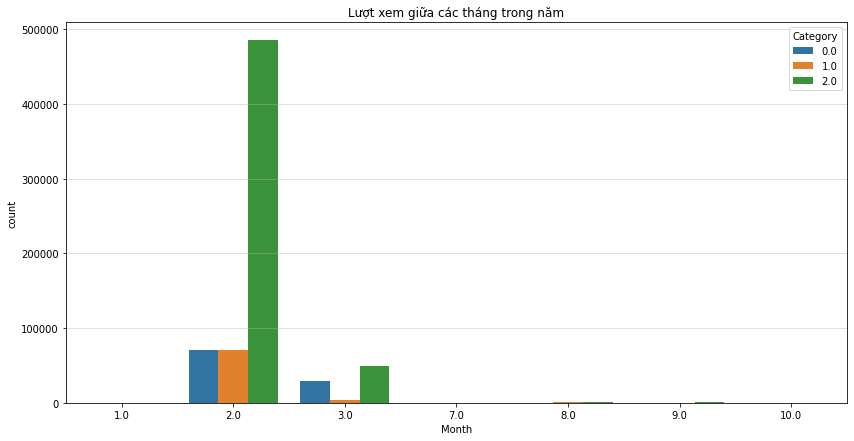

In [625]:
#@title
plt.figure(figsize=(14,7))
sns.countplot(df, x= 'Month', hue='Category')
plt.title('Lượt xem giữa các tháng trong năm')
# red_patch = mpatches.Patch(color='blue', label='Người đăng kí dưới 1 tháng')
# a = mpatches.Patch(color='orange', label='Giai đoạn ổn định người đăng kí trên 2 tháng')
# b = mpatches.Patch(color='green', label='Tháng cuối của người đăng kí trên 2 tháng')
# plt.legend(handles=[red_patch, a, b], loc='upper right', fontsize=10)
plt.grid(axis='y', alpha=0.5)
plt.show()

> **Nhận xét:**

>> Các khách hàng có thời gian đăng kí dưới 1 tháng thì lượng tương tác tập trung hoàn toàn vào tháng 2 và 3 (đây là tháng đối tượng này đăng kí sử dụng)

>> Tháng cuối cùng trước khi hủy dịch vụ có lượng tương tác cao nhất.

##### **3.3 Khác biệt về nội dung xem**

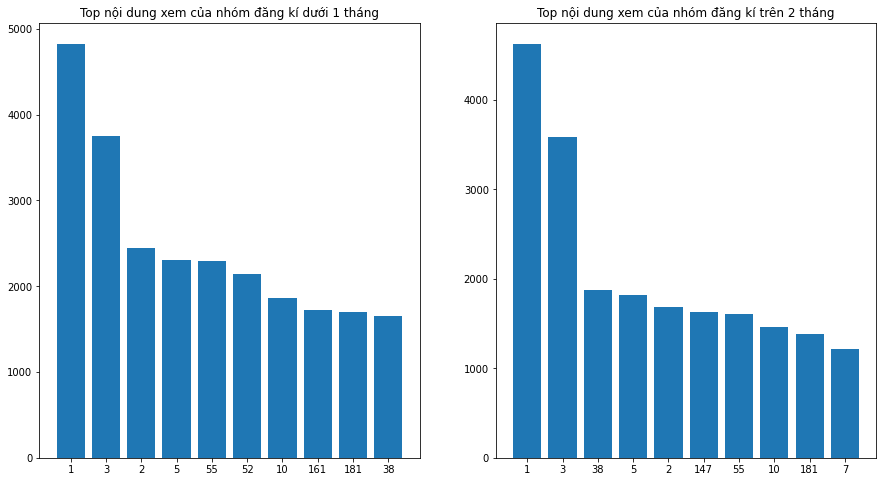

In [628]:
#@title
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))

most_view_item = df[df['Category']==0]['ItemId'].value_counts()[1:11]
ax1.bar(most_view_item.index, most_view_item.values)
most_view_item = df[df['Category']==1]['ItemId'].value_counts()[1:11]
ax2.bar(most_view_item.index, most_view_item.values)

ax1.title.set_text('Top nội dung xem của nhóm đăng kí dưới 1 tháng')
ax2.title.set_text('Top nội dung xem của nhóm đăng kí trên 2 tháng')

> **Nhận xét:**

>> Ta thấy có sự khác biệt về nội dung xem giữa 2 nhóm. Có 2 nội dung là 161 nằm trong top nôi dung của nhóm người đăng kí dưới 1 tháng nhưng lại không xuất hiện trong top nội dung xem của nhóm người đăng kí trên 2 tháng. Và 147 ngược lại.

>> Có thể suy ra rằng nhóm người đăng kí dưới 1 tháng có thể đăng kí để xem một số chương trình được phát sóng trong thời gian nhất định